# EXAMPLE: understanding how the structure shape/configuration influences the stiffness

Here we will have a look at a random beam structure. Notice that this structure can be seen as composed by 2 substructures, one above the other. The inferior one is a simple isocele triangle, with small angles. We expect to see a very stiff behaviour from it. The upper one instead is a trapezoid (sharing one side with the triangle), and definitely more voluminous than the substrucutre below. We expect this part to present a very high compliance and deform a lot.

Of course the load conditions between the upper one and the lower one are different, the above structure is more voluminous and consequently the loads have a greater leverage etc. This case wants just to qualitatively highlight the stiffness differences in various areas of the structures

In [16]:
import fem_toolbox as ft

In [17]:
# reading geometry
nodes_coords_beam, beam_connectivity, beam_crossSection, mat_properties = ft.geometry.read_structure('../Tutorials/geometry&boundary-files/myStrangeStructure.txt')

In [18]:
# meshing
elements_per_beam = 5

fem_nodes, fem_elements, element_crossSections = ft.mesh.discretize(nodes_coords_beam, beam_connectivity, beam_crossSection, elements_per_beam=elements_per_beam)

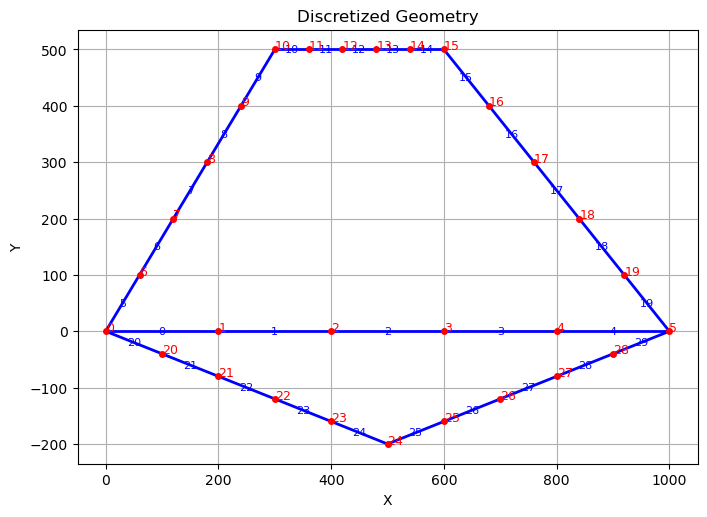

In [19]:
# geometry and mesh visualization
ft.mesh.plot_discretized_geometry_2D(nodes_coords_beam, beam_connectivity, fem_nodes, fem_elements)

In [20]:

_ , bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values = ft.BC_loads.read_bc_and_forces("../Tutorials/geometry&boundary-files/strangeStructure_BC.txt")

# define element type (frame element (2d beam)-> ndofs_per_element = 3)
ndofs_per_node = 3

# validate constraints
num_nodes= fem_nodes.shape[0]
ft.BC_loads.validate_constraints(num_nodes, ndofs_per_node, bc_nodes, bc_dofs)

Constraint check passed: 6 DOFs constrained out of 87.


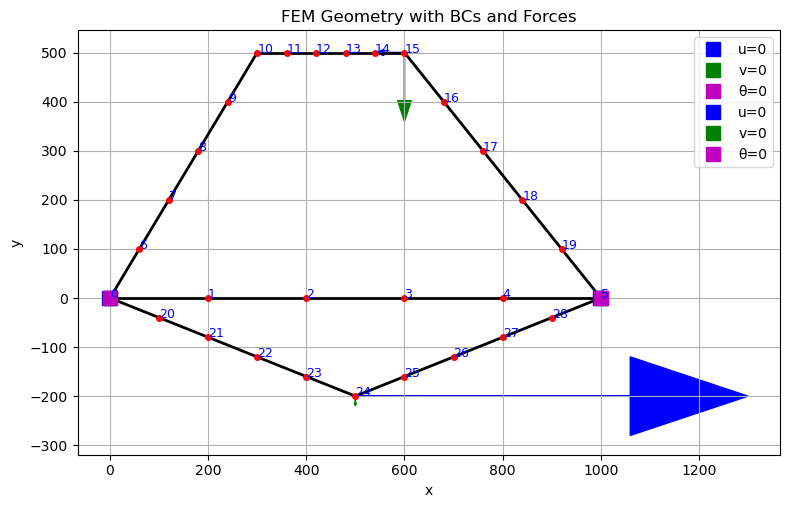

In [21]:
# visual validation before solving 
ft.BC_loads.plot_fem_model(fem_nodes, fem_elements, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, scale_force=0.02)

In [22]:
# assemble global matrices
K_frame = ft.femsolver.assembleK(ft.elements.k_beam2d, ft.elements.rotation_2d, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node=3)

M_frame = ft.femsolver.assembleM(ft.elements.m_beam2d, ft.elements.rotation_2d, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node=3)

In [23]:

# build global force vector
num_dofs = K_frame.shape[0]
dofs_per_node = 3   # 2d beam element
f_ext = ft.femsolver.build_force_vector(f_nodes, f_dofs, f_values, num_dofs, dofs_per_node)

In [24]:

# static analysis
u = ft.femsolver.static_analysis(K_frame, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node=3)

# modal analysis
frequencies, mode_shapes, free_dofs = ft.femsolver.modal_analysis(K_frame, M_frame, bc_nodes, bc_dofs, ndof_per_node=3)

Mode 1: 5.92 Hz
Mode 2: 6.47 Hz
Mode 3: 13.66 Hz
Mode 4: 15.35 Hz
Mode 5: 17.89 Hz


In [25]:

# stress computation
cross_section = "rectangle"

stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = ft.postprocessing.eval_stress(ft.elements.k_beam2d, ft.elements.rotation_2d, u,fem_elements, fem_nodes, element_crossSections, mat_properties, cross_section, ndof_per_node=ndofs_per_node)

# reaction components
reactions, _ = ft.postprocessing.compute_reaction_forces(K_frame, u, bc_nodes, bc_dofs, ndofs_per_node)


DOF 0: Reaction force = -17217.71 N
DOF 1: Reaction force = 11989.60 N
DOF 2: Reaction force = -409635.99 N
DOF 15: Reaction force = -19782.29 N
DOF 16: Reaction force = -3989.60 N
DOF 17: Reaction force = -400766.81 N


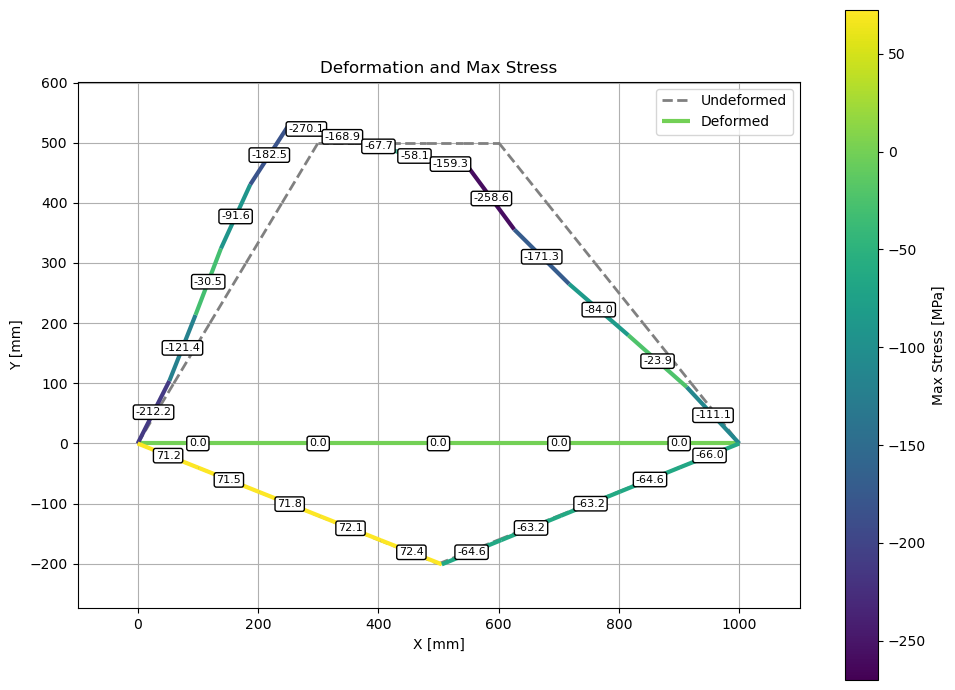

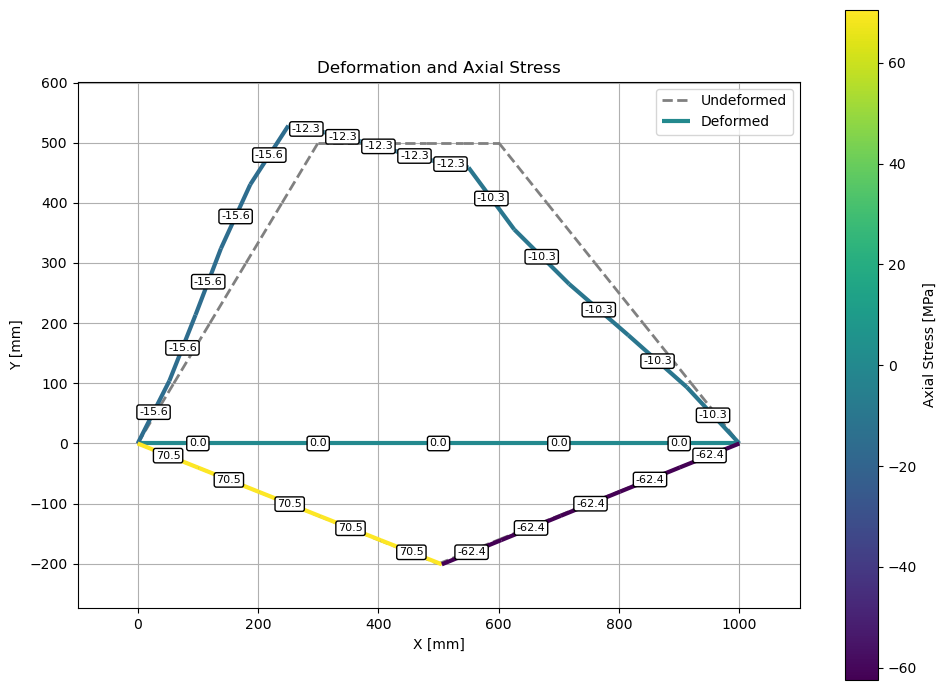

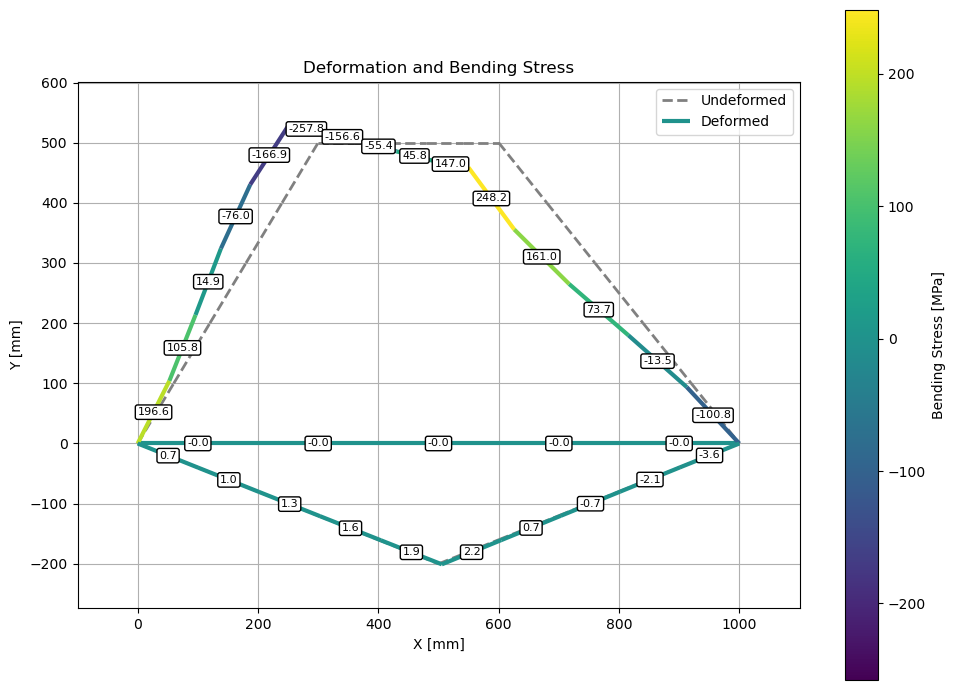

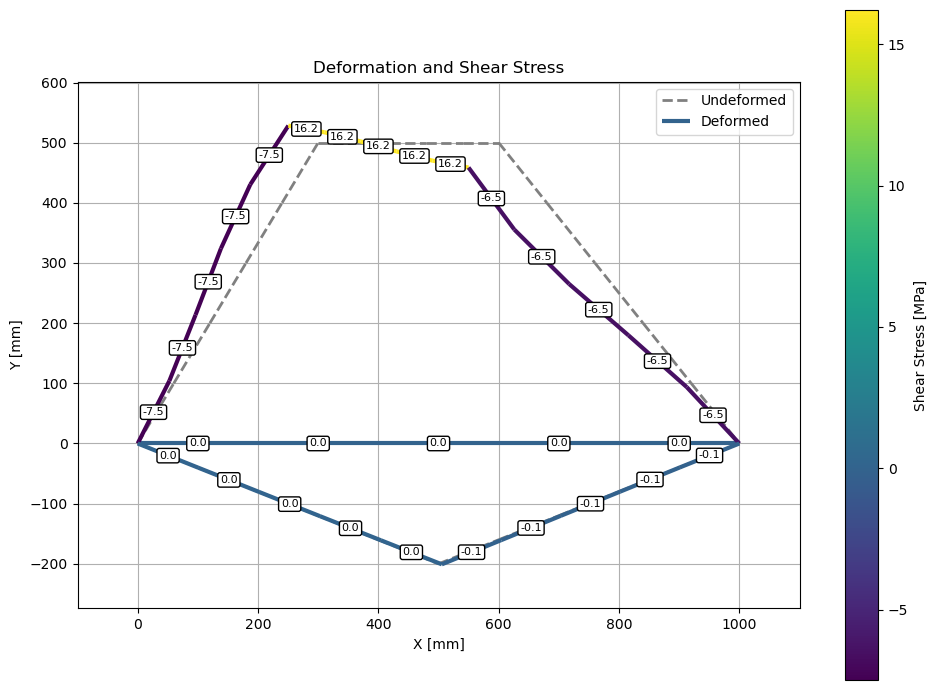

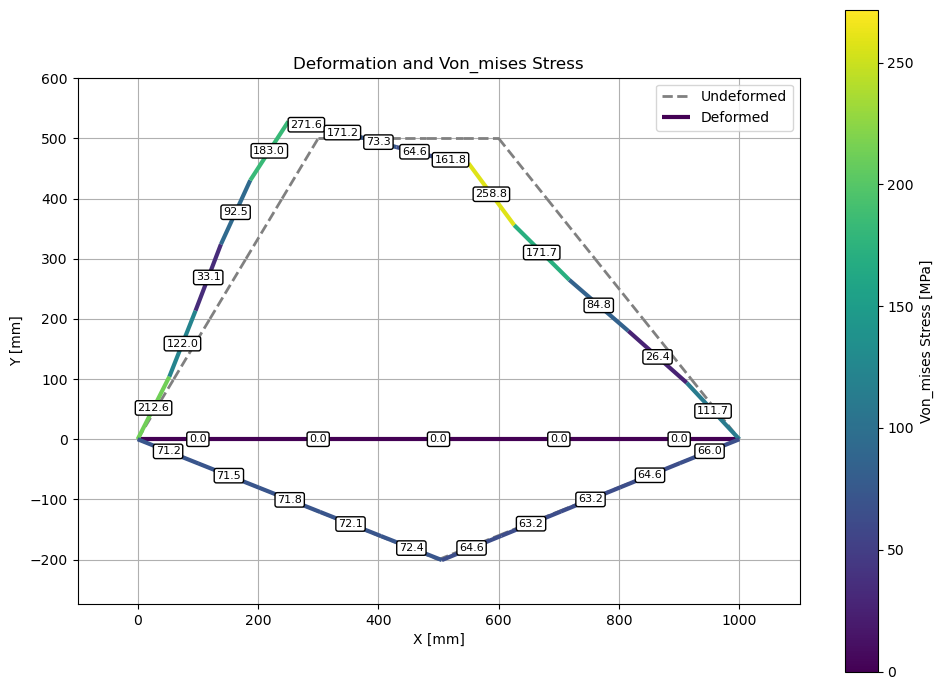

In [26]:
# visualization
stresses = {'max':stress_max,
            'axial':stress_axial,
            'bending':stress_bending,
            'shear':stress_shear,
            'von_Mises': von_mises_stress}

for stress_type in stresses.keys():
    ft.postprocessing.plot_2D_loaded_structure (fem_nodes, fem_elements, u, stresses[stress_type], stress_type=stress_type, ndof_per_node=3, scale=30, show_labels=True)


In [27]:
ft.postprocessing.animate_mode_shape_2D(mode_index=3, eigenvecs=mode_shapes, node_coords=fem_nodes, free_dofs=free_dofs, K=K_frame, elements=fem_elements, ndof_per_node=3, amplification=200)